In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('ggplot')

from models.RL import rl_utils, deterministic_rl, bb_net_rl, mushroom_utils, dropout_rl

import torch

## 0. Data preparation

#### Load mushroom dataset

In [31]:
mushroom_df, train_X, train_y, test_X, test_y = mushroom_utils.load_mushroom(train_frac=0.8)
dim_input = train_X.shape[1]
dim_action_space = 2

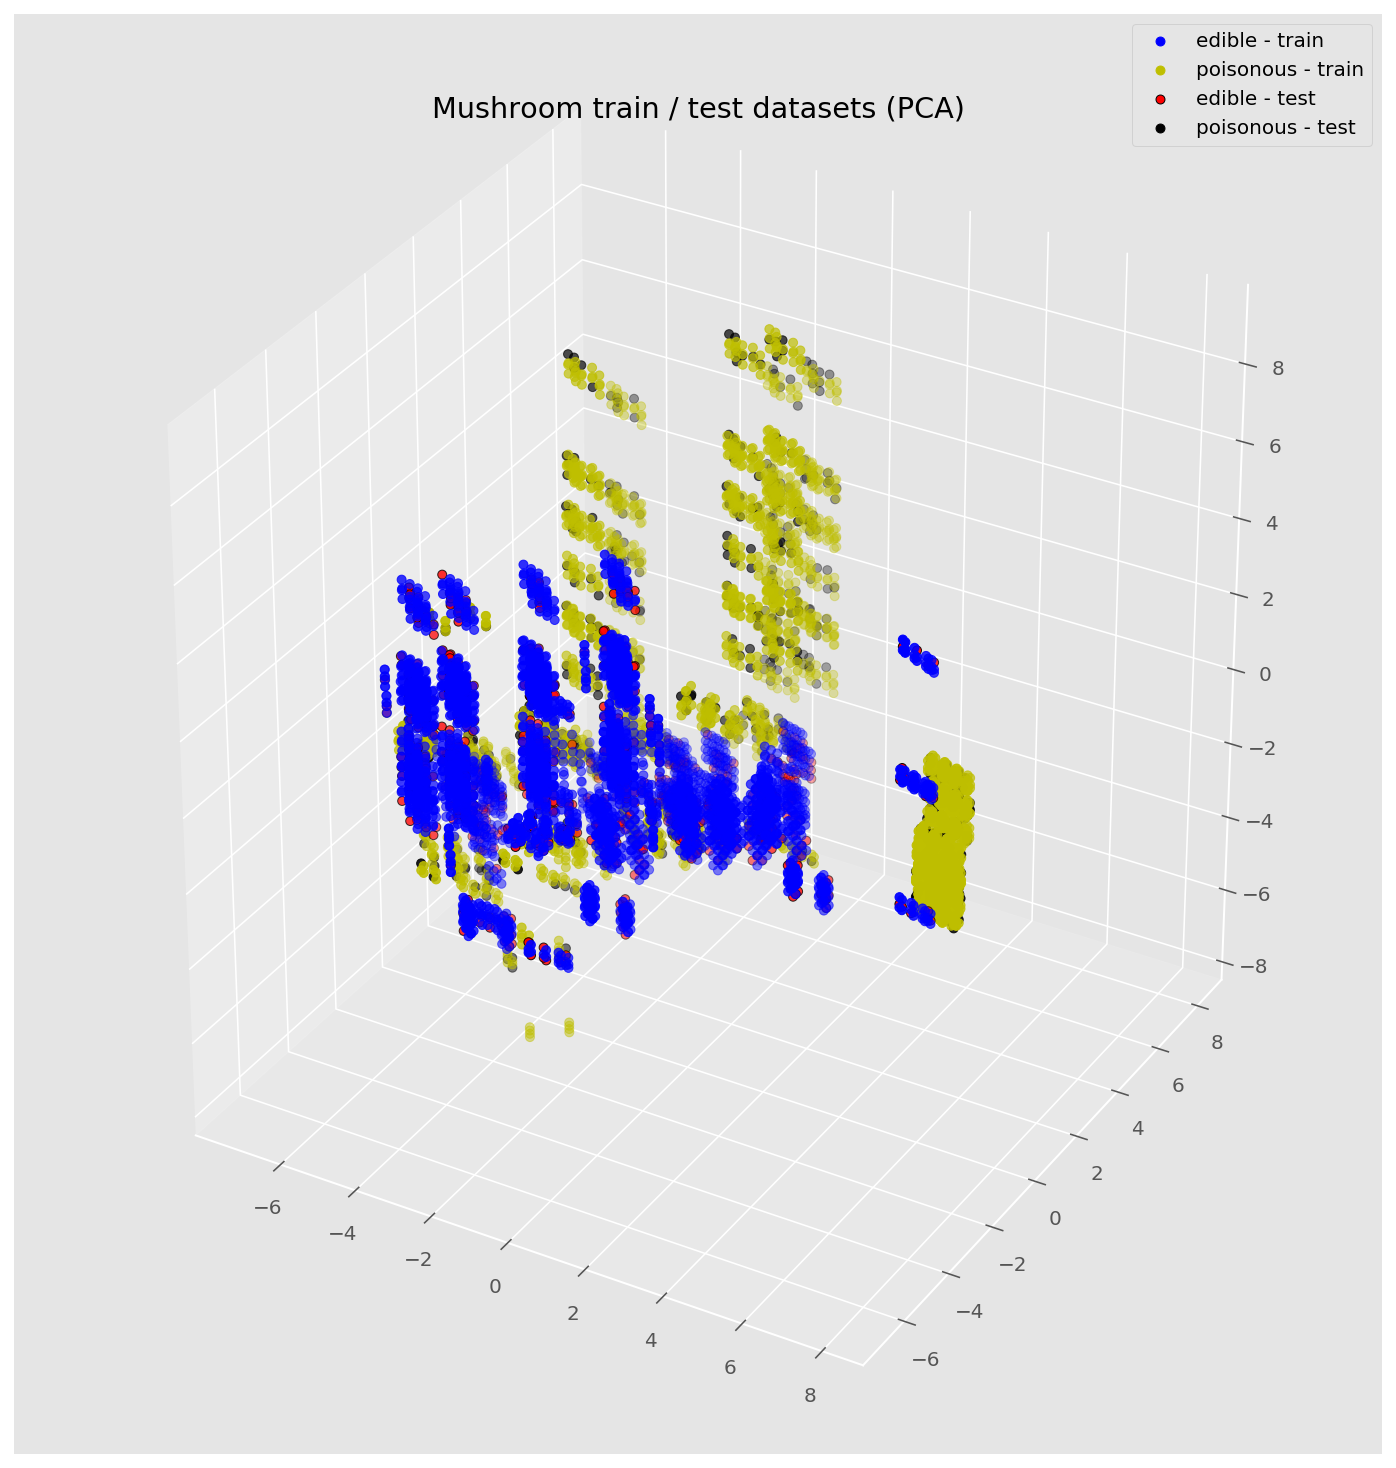

In [32]:
fig = plt.figure(1, figsize=(10, 10))
mushroom_utils.plot_points(mushroom_df, train_X, test_X, fig)
plt.title("Mushroom train / test datasets (PCA)")
plt.show()

In [33]:
X_train_tensor = torch.from_numpy(train_X.copy()).float().unsqueeze(dim=1)
y_train_tensor = torch.from_numpy(train_y.copy()).float()
X_test_tensor = torch.from_numpy(test_X.copy()).float().unsqueeze(dim=1)

In [82]:
N_RUNS = 10
N_EPISODES = 20000

## 1. $\epsilon$-greedy agents with deterministic nets

In [35]:
epsilons = [0, 0.03, 0.05]

regrets = np.zeros((len(epsilons), N_EPISODES + 1))
regrets_std = np.zeros_like(regrets)
for i, epsilon in enumerate(epsilons):
    regs = np.zeros((N_RUNS, N_EPISODES + 1))
    for run in range(N_RUNS):
        print(f'{epsilon:.3f} : sample {run + 1:2d} / {N_RUNS:2d}')
        net = deterministic_rl.DeterministicRLNet(100, dim_input, dim_action_space)
        agent_greedy = rl_utils.AgentGreedy(net, epsilon)
        rl_reg = deterministic_rl.DeterministicRLReg(X_train_tensor, y_train_tensor, agent_greedy, buffer_size=4096, minibatch_size=64, burn_in=256)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=0.005, weight_decay=1e-6)
        rl_reg.train(N_EPISODES, optimizer)
        regs[run] = rl_reg.hist['regret'].copy()
        clear_output()
    regrets[i] = regs.mean(axis=0)
    regrets_std[i] = regs.std(axis=0)
det_net = net

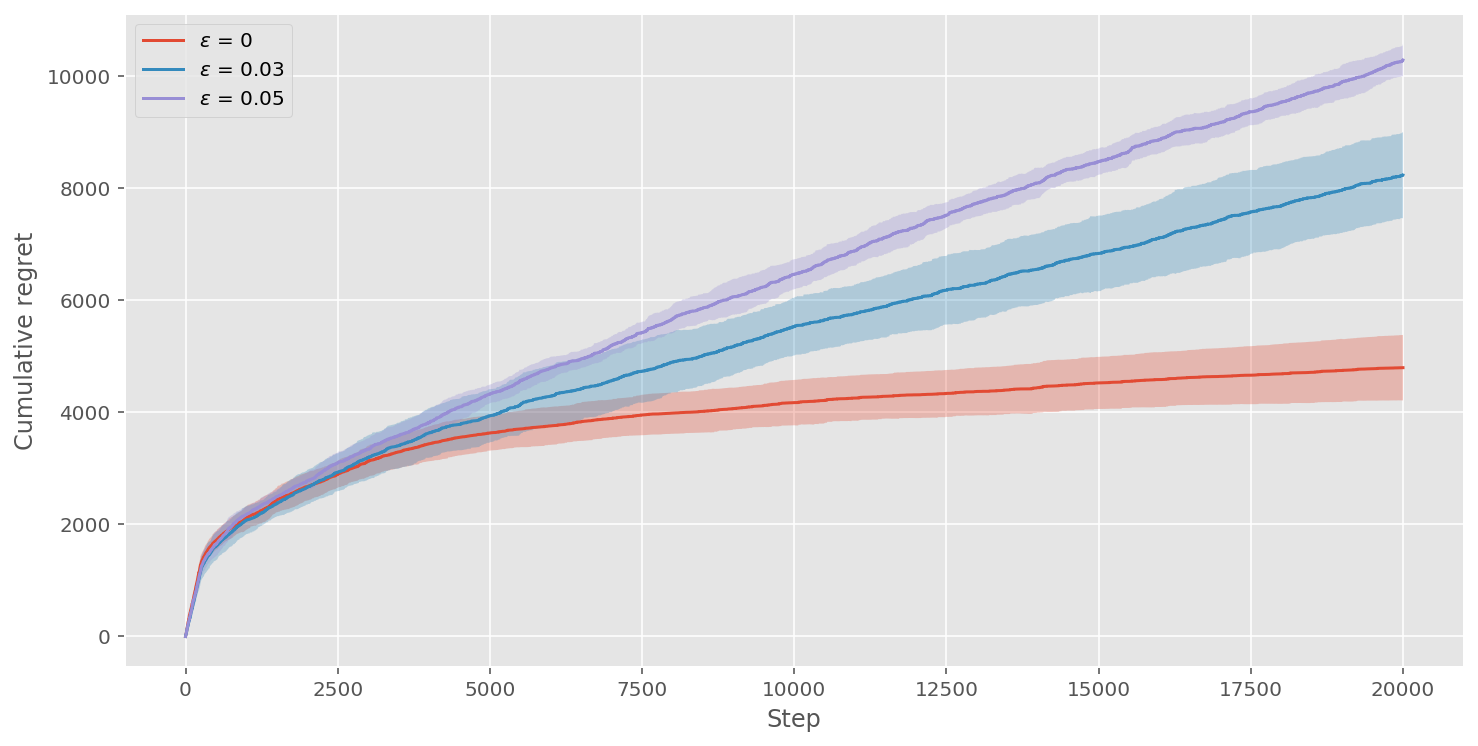

In [36]:
plt.figure(figsize=(12, 6))
for epsilon, regs, regs_std in zip(epsilons, regrets, regrets_std):
    plt.plot(regs, label=r"$\epsilon$ = {}".format(epsilon))
    plt.fill_between(np.arange(N_EPISODES + 1), regs - regs_std, regs + regs_std, alpha=0.3)
plt.legend()
plt.xlabel('Step')
plt.ylabel('Cumulative regret')
plt.show()

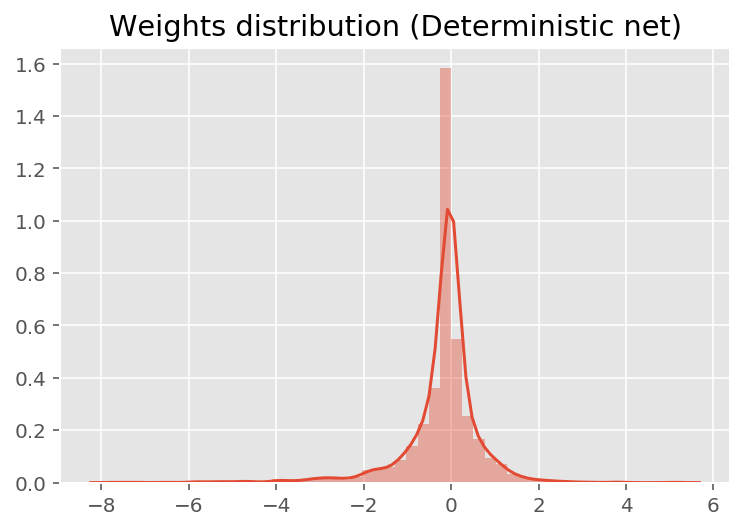

In [37]:
sns.distplot(det_net.weights_dist())
plt.title('Weights distribution (Deterministic net)')
plt.show()

#### Prediction performance on unseen data

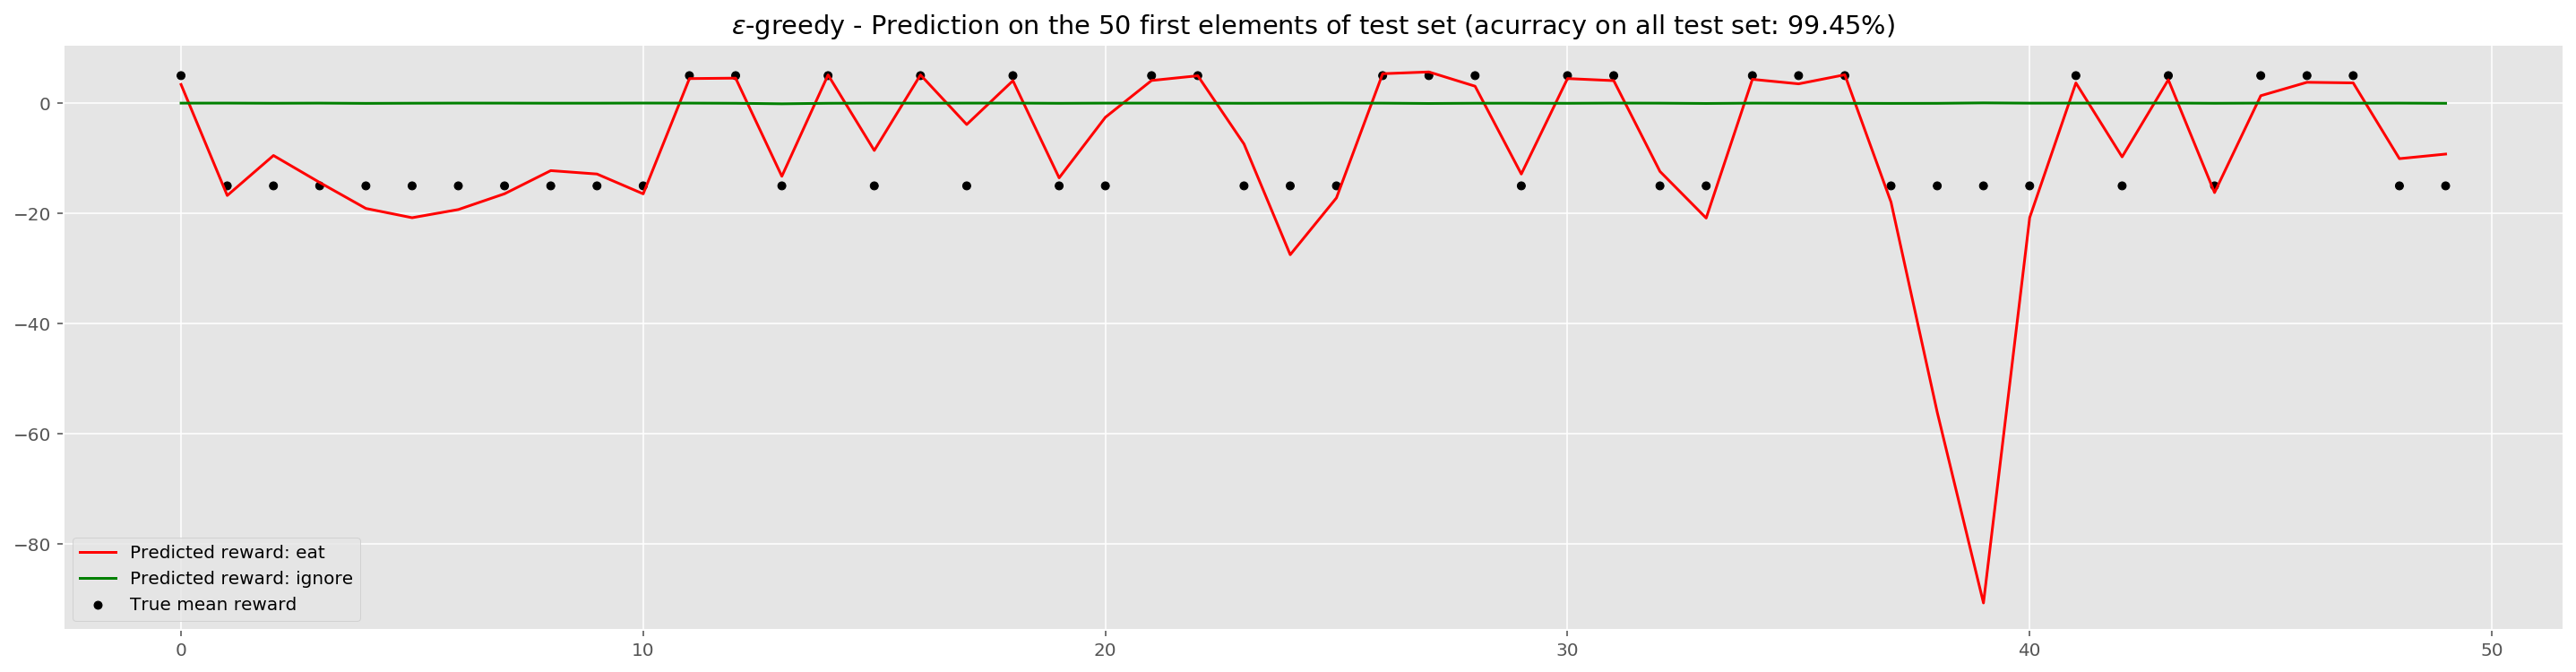

In [123]:
plt.figure(figsize=(25, 6))
N = 50
plt.plot(np.arange(N), det_net(X_test_tensor).squeeze().detach().numpy()[:N, 1], color='r', label='Predicted reward: eat')

estimates = np.zeros((MC, N))
for i in range(MC):
    estimates[i] = det_net(X_test_tensor).squeeze().detach().numpy()[:N, 0]
plt.plot(np.arange(N), det_net(X_test_tensor).squeeze().detach().numpy()[:N, 0], color='g', label='Predicted reward: ignore')

preds = 1 - det_net(X_test_tensor).squeeze().detach().numpy().argmax(axis=1)
S = 20 + 100 * (preds != test_y)

plt.scatter(np.arange(N), - test_y[:N] * 20 + 5, c='k', s=S[:N], label='True mean reward')
plt.legend()
acc = np.mean(det_net(X_test_tensor).squeeze().argmax(axis=1).numpy() == 1 - test_y)
plt.title(r'$\epsilon$-greedy - ' + f'Prediction on the {N} first elements of test set (acurracy on all test set: {acc * 100:2.2f}%)')
plt.show()

## 2. Dropout Agent

In [98]:
regs_dropout = np.zeros((N_RUNS, N_EPISODES + 1))
for run in range(N_RUNS):
    print(f'Sample {run + 1:2d} / {N_RUNS:2d}')
    dropout_net = dropout_rl.DropoutNet(100, dim_input, dim_action_space, p=0.25)
    agent_dropout = rl_utils.AgentDropout(dropout_net, sample=2)
    rl_reg = dropout_rl.DropoutRLReg(X_train_tensor, y_train_tensor, agent_dropout, buffer_size=4096, minibatch_size=64, burn_in=256)
    optimizer = torch.optim.Adam(dropout_net.parameters(), lr=0.003, weight_decay=1e-6)
    rl_reg.train(N_EPISODES, optimizer)
    regs_dropout[run] = rl_reg.hist['regret'].copy()
    clear_output()

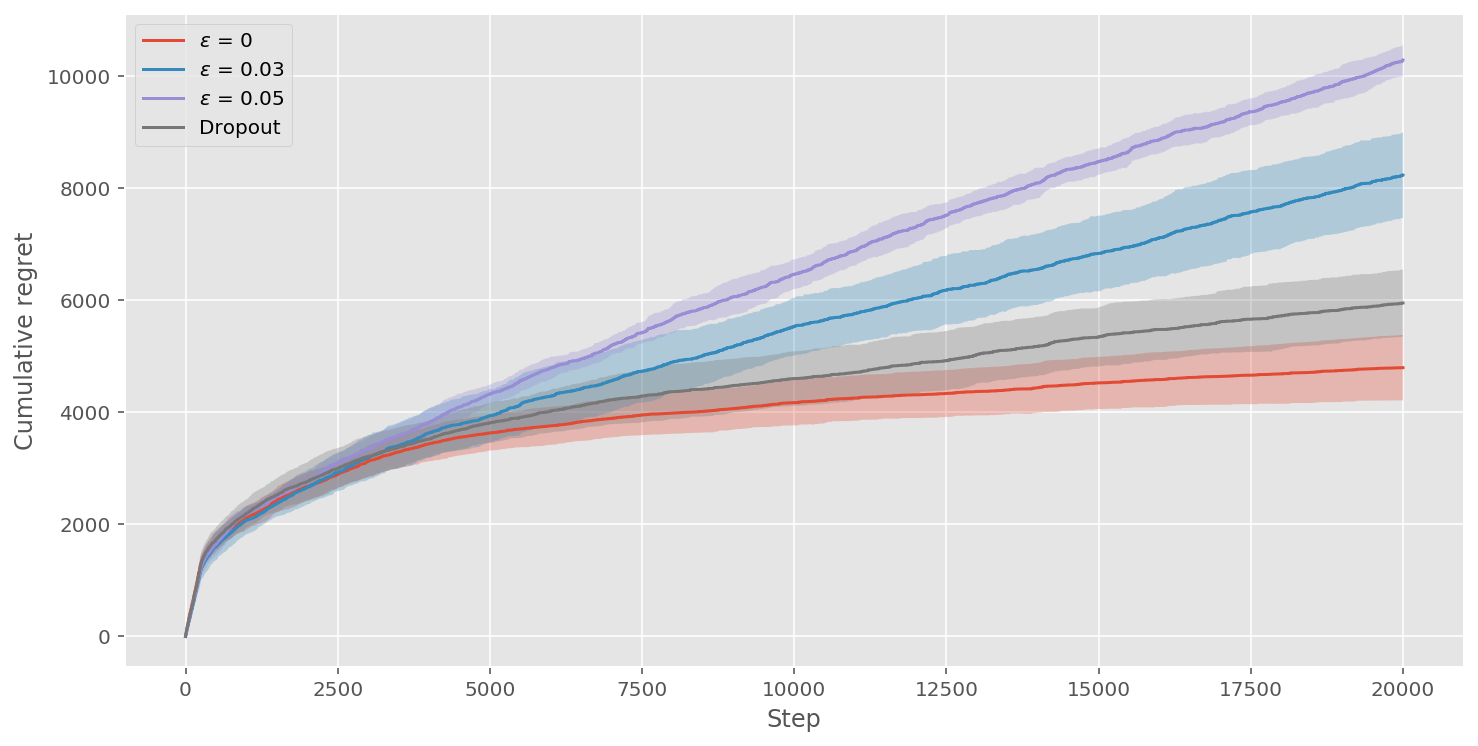

In [99]:
plt.figure(figsize=(12, 6))
for epsilon, regs, regs_std in zip(epsilons, regrets, regrets_std):
    plt.plot(regs, label=r"$\epsilon$ = {}".format(epsilon))
    plt.fill_between(np.arange(N_EPISODES + 1), regs - regs_std, regs + regs_std, alpha=0.3)
plt.plot(regs_dropout.mean(axis=0), label='Dropout')
plt.fill_between(np.arange(N_EPISODES + 1), regs_dropout.mean(axis=0) - regs_dropout.std(axis=0), regs_dropout.mean(axis=0) + regs_dropout.std(axis=0), alpha=0.3)
plt.legend()
plt.xlabel('Step')
plt.ylabel('Cumulative regret')
plt.show()

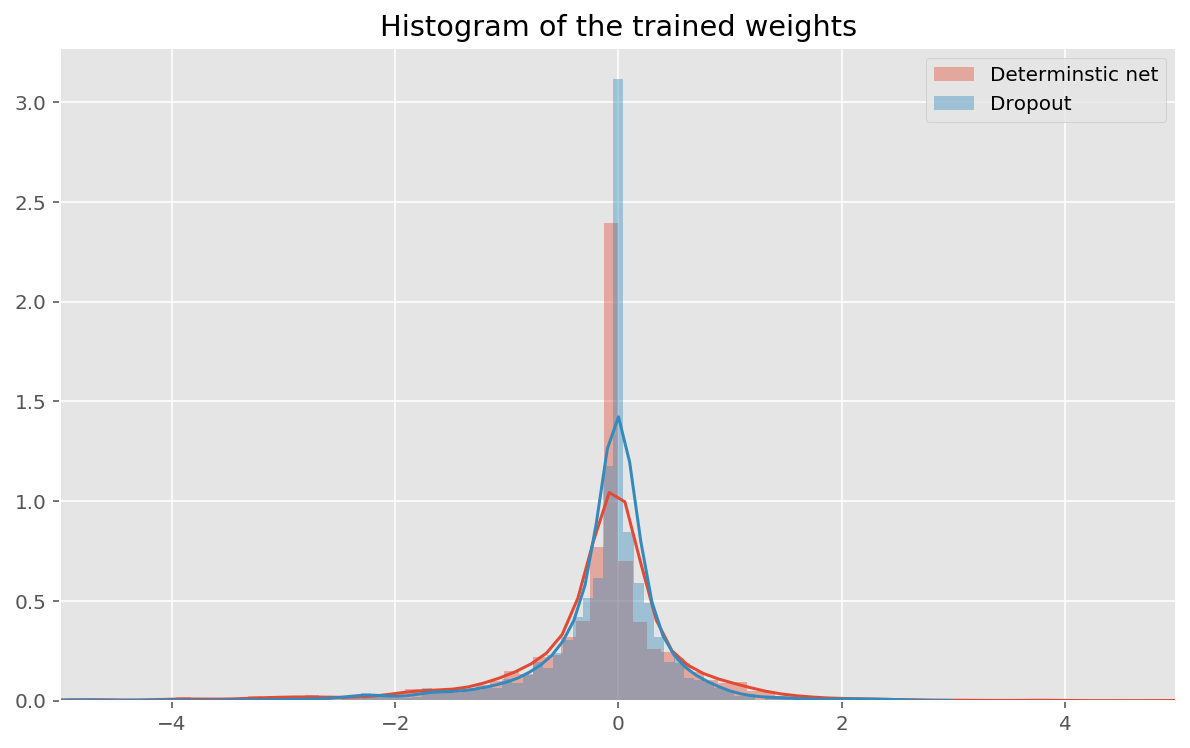

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
sns.distplot(det_net.weights_dist(), bins=100, ax=ax, label='Determinstic net')
sns.distplot(dropout_net.weights_dist(), bins=100, ax=ax, label='Dropout')
plt.title('Histogram of the trained weights')
plt.legend()
plt.show()

#### Prediction performance on unseen data

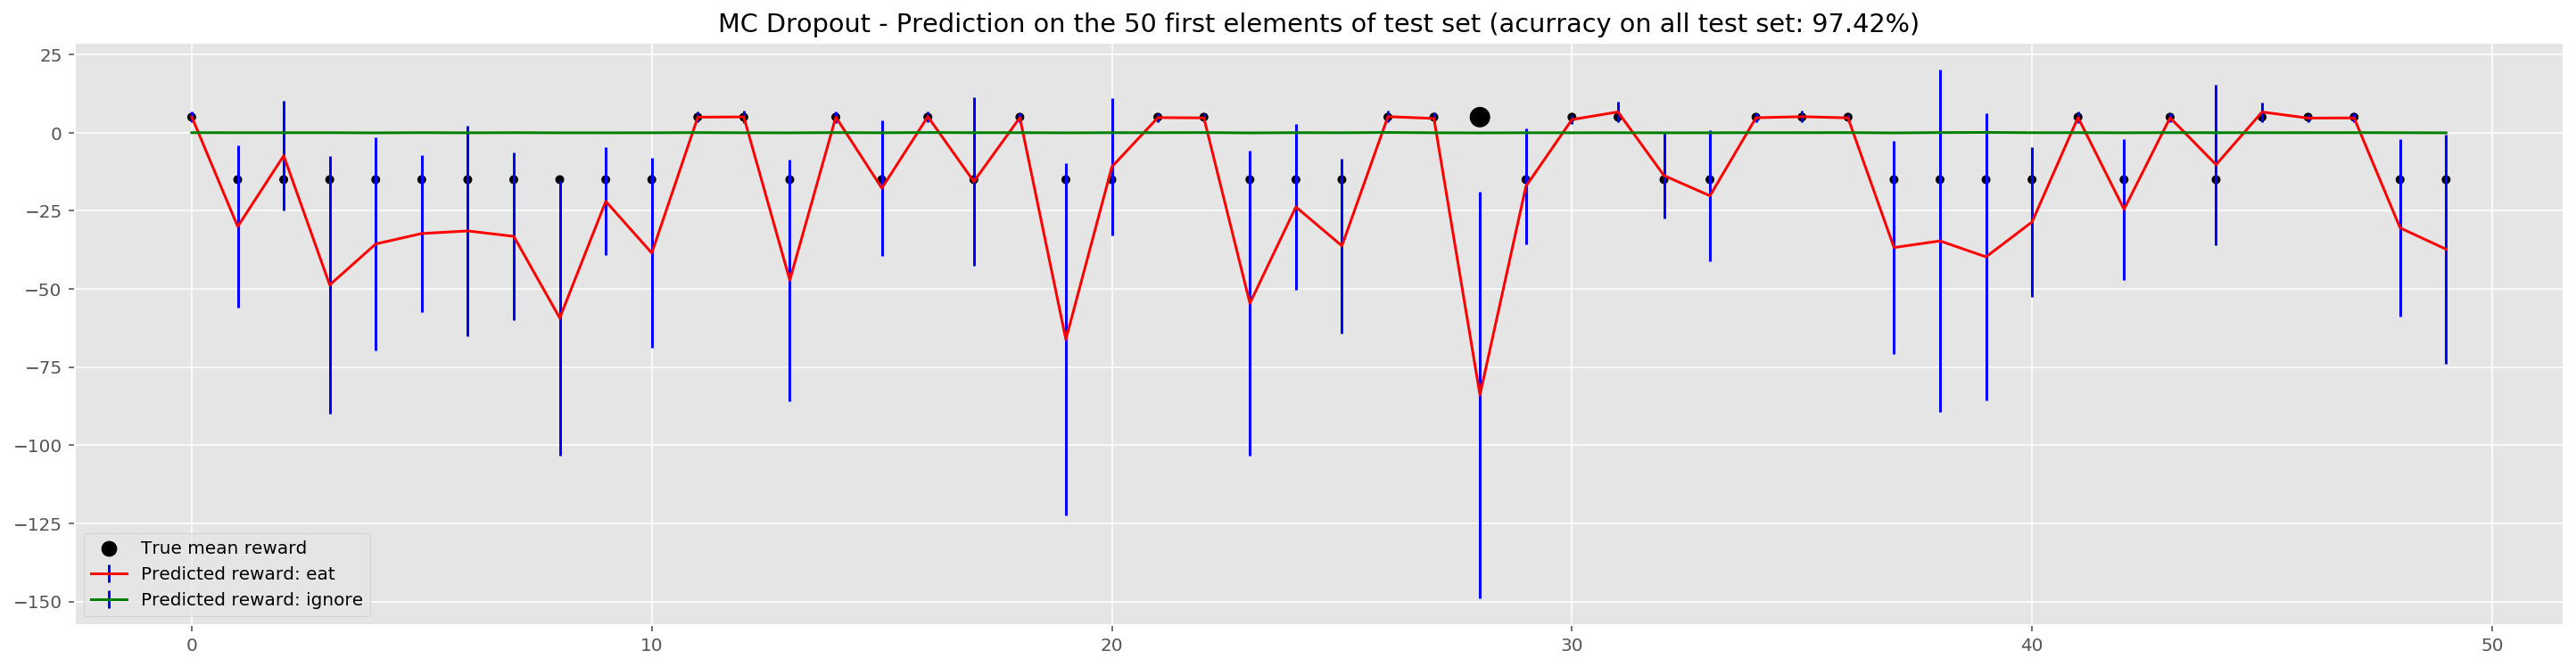

In [125]:
plt.figure(figsize=(25, 6))
N = 50
MC = 100

# Predicted rewards on 'eat' action
estimates = np.zeros((MC, N))
for i in range(MC):
    estimates[i] = dropout_net(X_test_tensor).squeeze().detach().numpy()[:N, 1]
plt.errorbar(np.arange(N), estimates.mean(axis=0), estimates.std(axis=0) * 3, color='r', ecolor='blue', label='Predicted reward: eat')

# Predicted rewards on 'ignore' action
estimates = np.zeros((MC, N))
for i in range(MC):
    estimates[i] = dropout_net(X_test_tensor).squeeze().detach().numpy()[:N, 0]
plt.errorbar(np.arange(N), estimates.mean(axis=0), estimates.std(axis=0) * 3, color='g', ecolor='blue', label='Predicted reward: ignore')

# Class prediction: edible / poisonous
preds = 1 - dropout_net(X_test_tensor).squeeze().detach().numpy().argmax(axis=1)
S = 20 + 100 * (preds != test_y)

plt.scatter(np.arange(N), - test_y[:N] * 20 + 5, c='k', s=S[:N], label='True mean reward')
plt.legend()
acc = np.mean(dropout_net(X_test_tensor).squeeze().argmax(axis=1).numpy() == 1 - test_y)
plt.title(f'MC Dropout - Prediction on the {N} first elements of test set (acurracy on all test set: {acc * 100:2.2f}%)')
plt.show()

## 3. Bayes by backprop Agent

In [116]:
regs_bayes = np.zeros((N_RUNS, N_EPISODES + 1))
prior_parameters = {'sigma1': 1, 'sigma2': 1e-6, 'pi': 0.5}
for run in range(N_RUNS):
    print(f'Sample {run + 1:2d} / {N_RUNS:2d}')
    bayes_net = bb_net_rl.BayesBackpropRLNet(100, dim_input, dim_action_space, prior_parameters, sigma=0.02)
    agent_bb = rl_utils.AgentBayesBackprop(bayes_net, sample=5)
    rl_reg = bb_net_rl.BayesRLReg(X_train_tensor, y_train_tensor, agent_bb, buffer_size=4096, minibatch_size=64, burn_in=256)
    optimizer = torch.optim.Adam(bayes_net.parameters(), lr=0.07, weight_decay=1e-6)
    rl_reg.train(N_EPISODES, optimizer)
    regs_bayes[run] = rl_reg.hist['regret'].copy()
    clear_output()

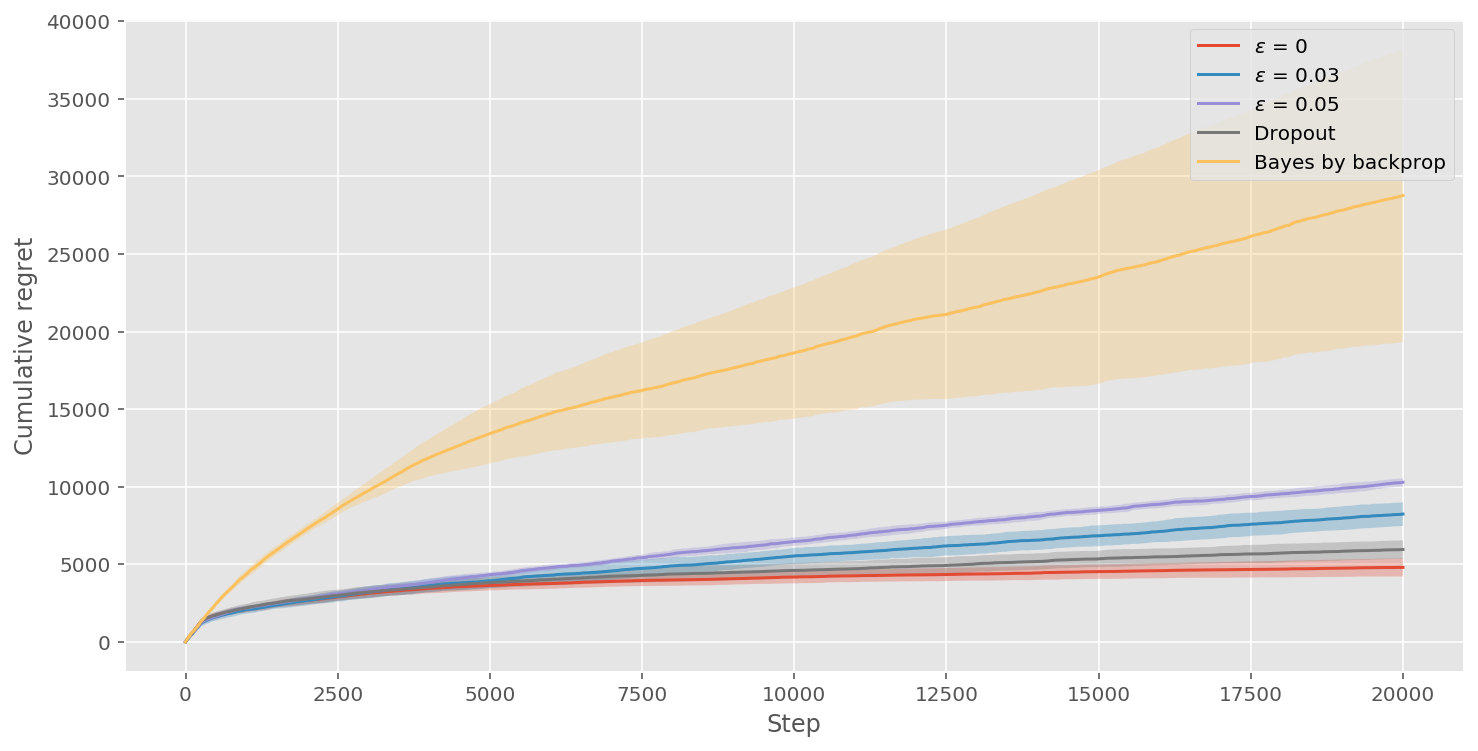

In [117]:
plt.figure(figsize=(12, 6))

for epsilon, regs, regs_std in zip(epsilons, regrets, regrets_std):
    plt.plot(regs, label=r"$\epsilon$ = {}".format(epsilon))
    plt.fill_between(np.arange(N_EPISODES + 1), regs - regs_std, regs + regs_std, alpha=0.3)
    
plt.plot(regs_dropout.mean(axis=0), label='Dropout')
plt.fill_between(np.arange(N_EPISODES + 1), regs_dropout.mean(axis=0) - regs_dropout.std(axis=0), regs_dropout.mean(axis=0) + regs_dropout.std(axis=0), alpha=0.3)

plt.plot(regs_bayes.mean(axis=0), label='Bayes by backprop')
plt.fill_between(np.arange(N_EPISODES + 1), regs_bayes.mean(axis=0) - regs_bayes.std(axis=0), regs_bayes.mean(axis=0) + regs_bayes.std(axis=0), alpha=0.3)

plt.legend()
plt.xlabel('Step')
plt.ylabel('Cumulative regret')
plt.show()

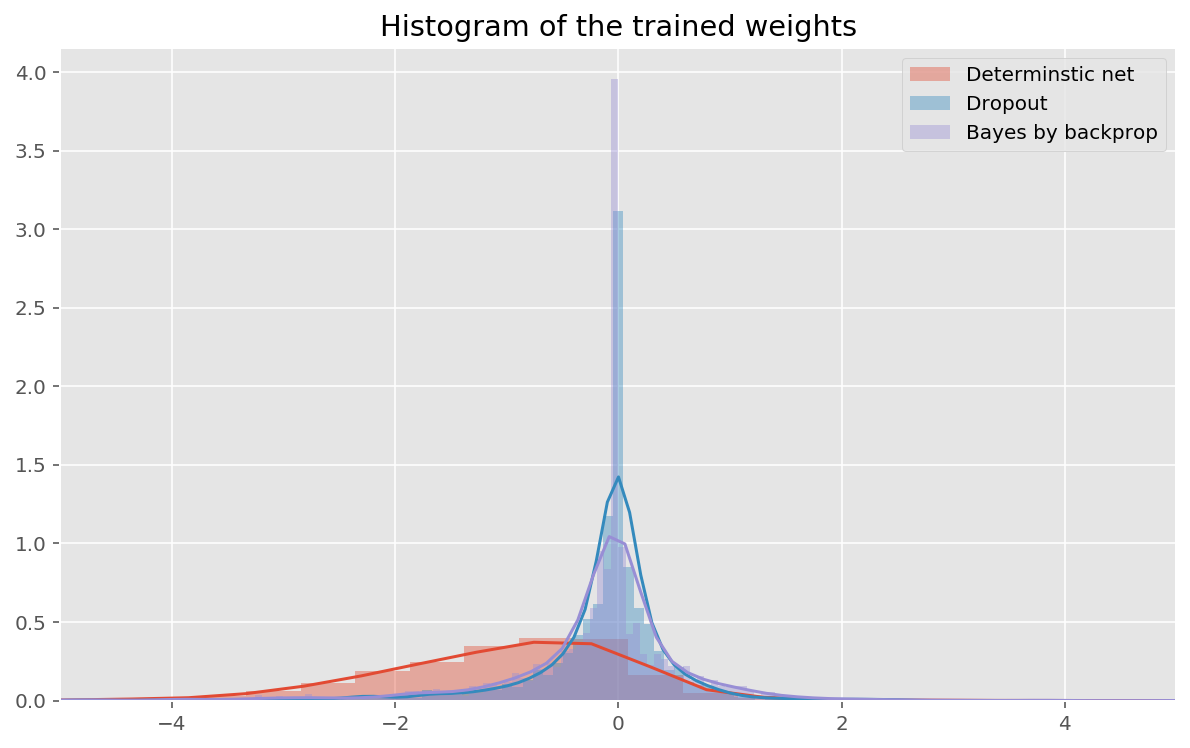

In [118]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 5)
sns.distplot(bayes_net.weights_dist(), bins=100, ax=ax, label='Determinstic net')
sns.distplot(dropout_net.weights_dist(), bins=100, ax=ax, label='Dropout')
sns.distplot(det_net.weights_dist(), bins=200, ax=ax, label='Bayes by backprop')
plt.title('Histogram of the trained weights')
plt.legend()
plt.show()

#### Prediction performance on unseen data

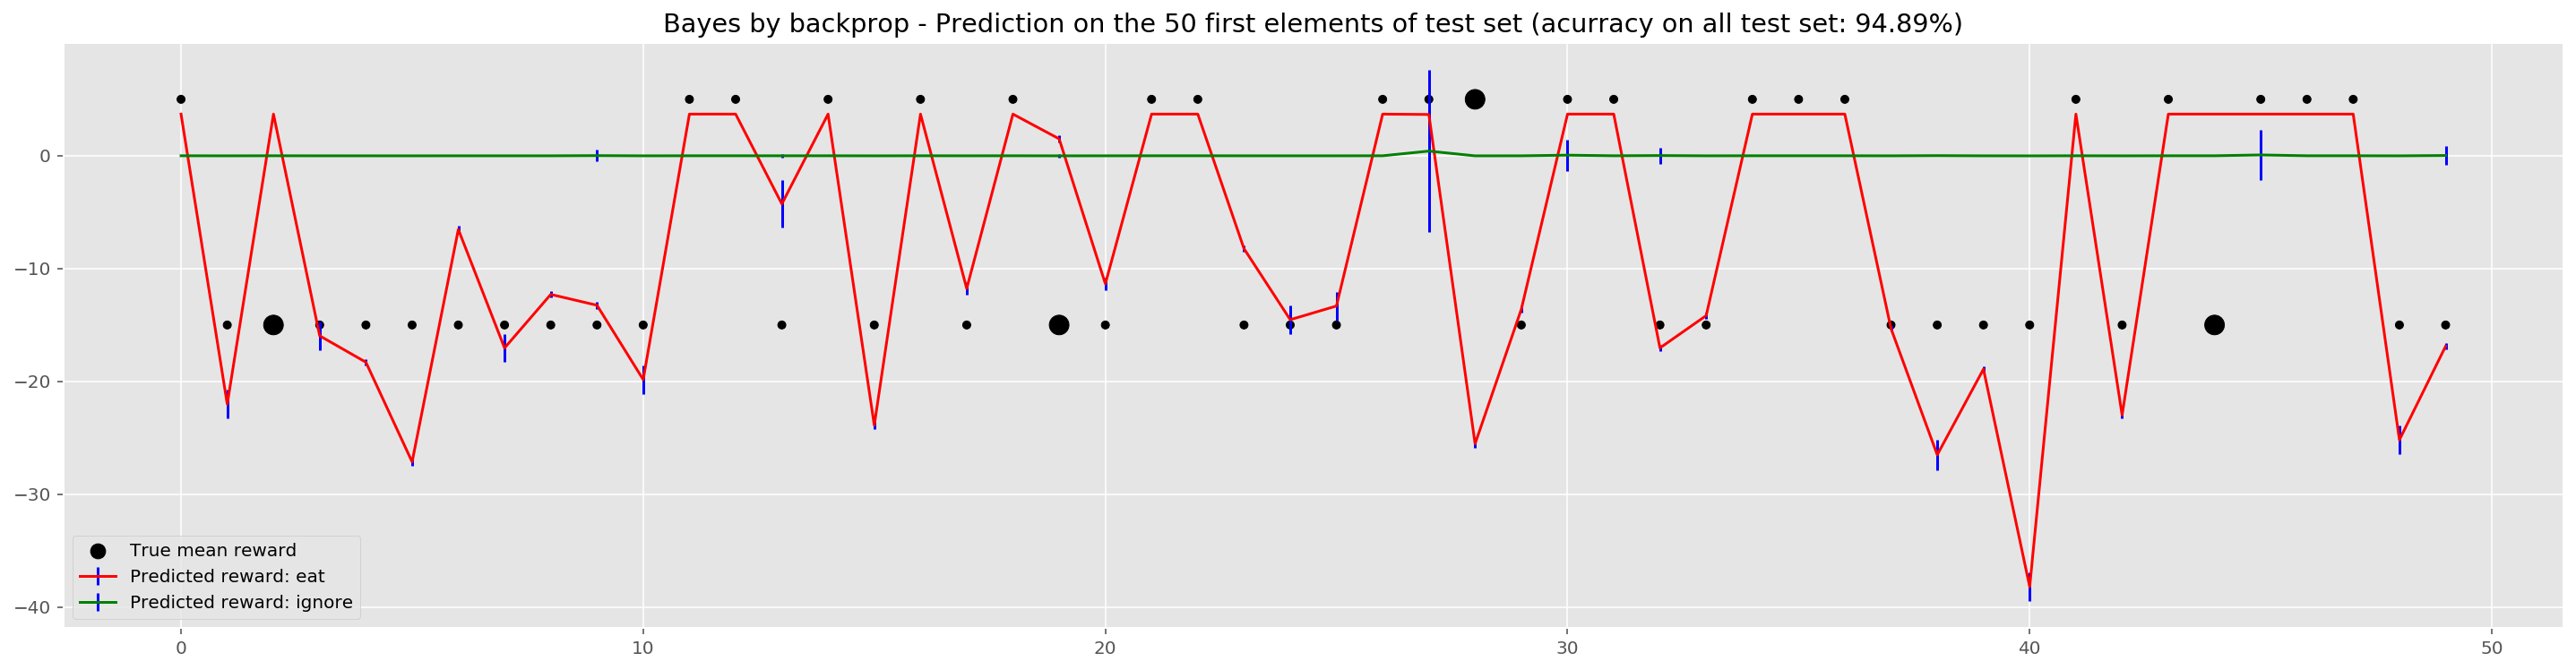

In [126]:
plt.figure(figsize=(25, 6))
N = 50
MC = 100

# Predicted rewards on 'eat' action
estimates = np.zeros((MC, N))
for i in range(MC):
    estimates[i] = bayes_net(X_test_tensor).squeeze().detach().numpy()[:N, 1]
plt.errorbar(np.arange(N), estimates.mean(axis=0), estimates.std(axis=0) * 3, color='r', ecolor='blue', label='Predicted reward: eat')

# Predicted rewards on 'ignore' action
estimates = np.zeros((MC, N))
for i in range(MC):
    estimates[i] = bayes_net(X_test_tensor).squeeze().detach().numpy()[:N, 0]
plt.errorbar(np.arange(N), estimates.mean(axis=0), estimates.std(axis=0) * 3, color='g', ecolor='blue', label='Predicted reward: ignore')

# Class prediction: edible / poisonous
preds = 1 - bayes_net(X_test_tensor).squeeze().detach().numpy().argmax(axis=1)
S = 20 + 100 * (preds != test_y)

plt.scatter(np.arange(N), - test_y[:N] * 20 + 5, c='k', s=S[:N], label='True mean reward')
plt.legend()
acc = np.mean(bayes_net(X_test_tensor).squeeze().argmax(axis=1).numpy() == 1 - test_y)
plt.title(f'Bayes by backprop - Prediction on the {N} first elements of test set (acurracy on all test set: {acc * 100:2.2f}%)')
plt.show()